# Crop Prediction

Agricultural success heavily relies on understanding the unique interplay between soil composition and climatic conditions. This project explores a dataset that encompasses a diverse set of soil elements and weather characteristics, accompanied by corresponding recommended crops for each distinct situation.

**The Central Question: What crop should be grown given certain soil and weather conditions?**

By treating this as a classification problem, the aim is to develop a predictive model capable of recommending the most suitable crop based on specific environmental factors. 

Through the application of machine learning techniques, valuable insights can be unlocked into the complex relationships between soil nutrients, weather patterns, and optimal crop selection. Ultimately, the outcomes of this project have the potential to influence agricultural decision-making, leading to sustainable farming practices, improved crop yields, and efficient resource allocation in the agriculture sector.

(Dataset obtained from: https://www.kaggle.com/datasets/atharvaingle/crop-recommendation-dataset)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.metrics import accuracy_score
import warnings


warnings.filterwarnings(action="ignore", category=UserWarning)

seed = 123
test_size = 0.3
n_splits = 10
n_repeats = 2

In [3]:
data_path = "Z:/ITTI_Data_Science/datasets/Crop_recommendation.csv"
data = pd.read_csv(data_path) #sep = ';'

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


#### This dataset contains the following independent variables:
- **N, P, K**: Nitrogen, Phosphorus and Potassium soil composition

- **Temperature**: Temperature in degree Celsius

- **Humidity**: Relative humidity in %

- **pH**: pH value of the soil

- **Rainfall**: Rainfall in mm

#### As well as the target variable:
- **Crop**: Recommended crop, categorical

In [5]:
data.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [6]:
data

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


A briefly exploratory data analysis is performed. First, it must be checked that there are no null values in the dataframe. 

In [7]:
data.isnull().any()

N              False
P              False
K              False
temperature    False
humidity       False
ph             False
rainfall       False
label          False
dtype: bool

Renaming the "label" variable to "crop" to enhance interpretability

In [8]:
data.rename(columns={'label': 'crop'}, inplace=True)

Plotting the explanatory variables against the target variable using different boxplots. It is important to check for overlap between categories, as if there is substantial overlap, it may be challenging for the explanatory variable alone to distinguish between categories.

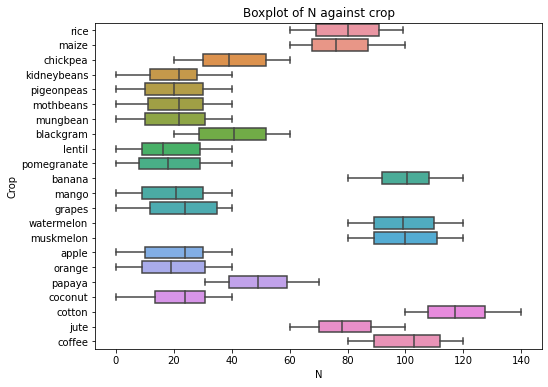

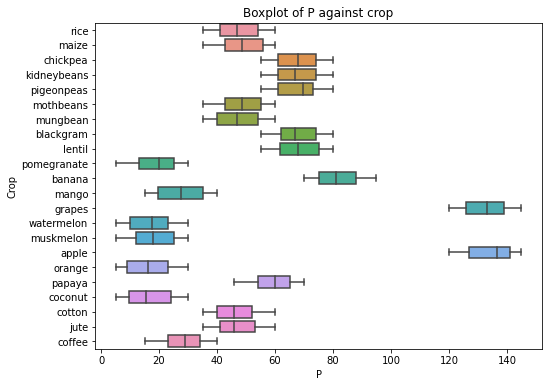

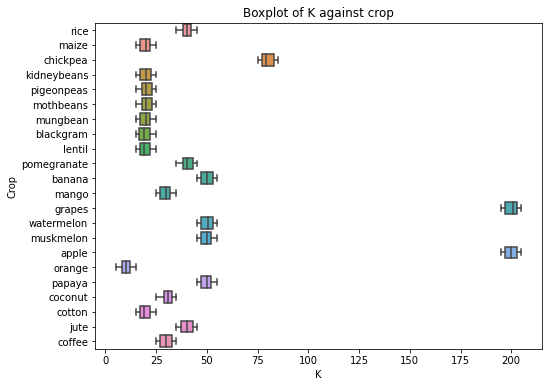

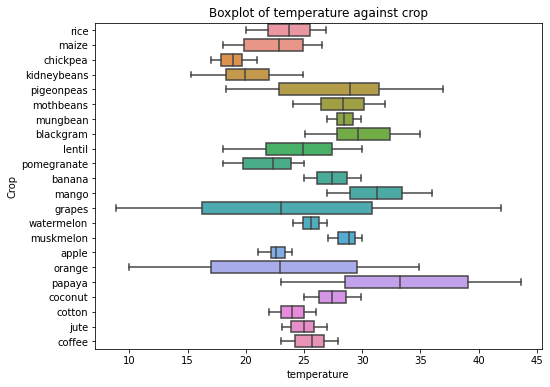

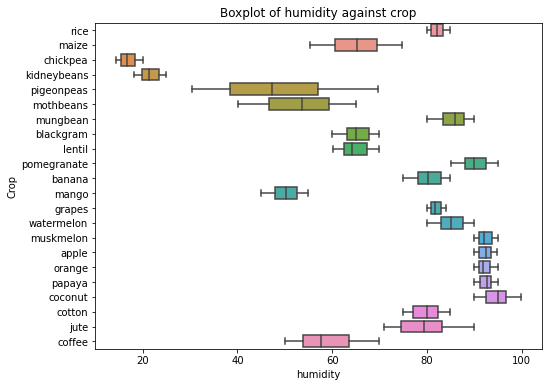

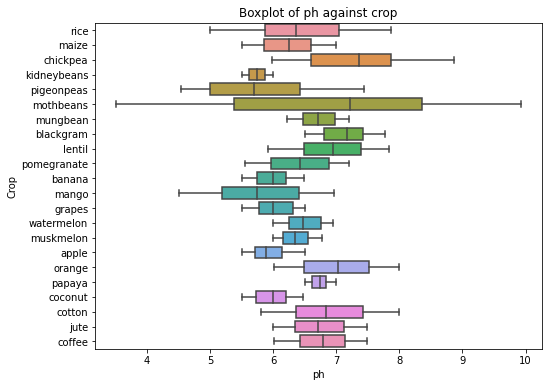

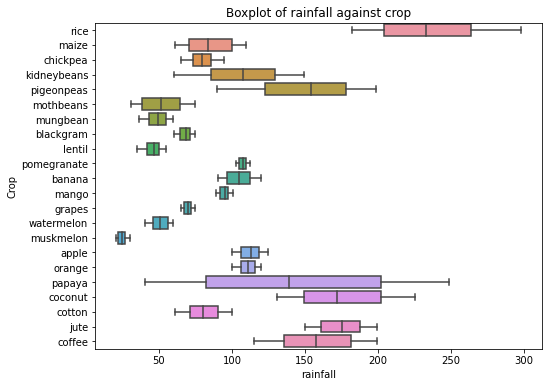

In [9]:
numerical_variables = data.select_dtypes(exclude="object").columns

# Create multiple box plots for each numerical variable against the target categorical variable
for num_var in numerical_variables:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data, x=num_var, y="crop")
    plt.title(f"Boxplot of {num_var} against crop")
    plt.xlabel(num_var)
    plt.ylabel("Crop")
    plt.show()

Data splitting and cross validation. Cross validation is a valuable technique that helps detecting overfitting issues and lets optimize hyperparameters

In [10]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(["crop"], axis=1),
                                                    data["crop"],
                                                    test_size=test_size,
                                                    random_state=seed)

# Cross validation
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

eval_metric = 'accuracy'

It is good practice to apply the StandardScaler function to the numerical variables, as it ensures that all features are on a similar scale. It is also advisable to standarize the variables so that distance-based algorithms, such as K-Nearest Neighbors and Support Vector Machines, can accurately calculate the distances

In [11]:
scale = StandardScaler().fit(x_train.select_dtypes(exclude="object"))

x_train_scale = scale.transform(x_train.select_dtypes(exclude="object"))
x_test_scale = scale.transform(x_test.select_dtypes(exclude="object"))

x_train_scale = pd.DataFrame(x_train_scale, columns = x_train.select_dtypes(exclude="object").columns)
x_test_scale = pd.DataFrame(x_test_scale, columns = x_train.select_dtypes(exclude="object").columns)

In [12]:
x_train_scale.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,1.540000e+03,1.540000e+03,1.540000e+03,1.540000e+03,1.540000e+03,1.540000e+03,1.540000e+03
mean,-8.434811e-17,5.471813e-17,-5.556297e-17,-4.385291e-16,6.985754e-17,-7.479587e-18,-1.291896e-16
std,1.000325e+00,1.000325e+00,1.000325e+00,1.000325e+00,1.000325e+00,1.000325e+00,1.000325e+00
min,-1.372471e+00,-1.480915e+00,-8.563061e-01,-3.357043e+00,-2.571765e+00,-3.785502e+00,-1.507444e+00
25%,-8.046027e-01,-7.739306e-01,-5.394581e-01,-5.632640e-01,-5.056623e-01,-6.421310e-01,-7.004281e-01
50%,-3.719413e-01,-6.694597e-02,-3.231967e-01,-1.202767e-02,4.063786e-01,-5.608951e-02,-1.711249e-01
75%,9.260429e-01,4.556079e-01,8.739284e-03,5.753999e-01,8.375667e-01,5.848151e-01,4.014225e-01
max,2.413316e+00,2.822469e+00,3.167161e+00,3.491324e+00,1.286578e+00,4.417275e+00,3.498077e+00


### DECISION TREE

It is possible now to start designing the first model

Basic model is set and stored in the `cart` variable. After that, `grid` is used to store the hyperparameters that will later be used by the `GridSearchCV` function. The model is finally fit using the ``x_train_scale`` and 
`y_train` objects

In [13]:
cart = DecisionTreeClassifier(random_state=seed)
grid=[{'max_depth':list(np.arange(5,11,1))}]

gs_cart = GridSearchCV(estimator=cart, param_grid=grid, scoring=eval_metric, cv=cv, n_jobs=1, return_train_score=False)

gs_cart = gs_cart.fit(x_train_scale, y_train)

In [14]:
cv_results = pd.DataFrame.from_dict(gs_cart.cv_results_)

cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010372,0.003868,0.002693,0.001342,5,{'max_depth': 5},0.454545,0.454545,0.337662,0.493506,...,0.512987,0.461039,0.493506,0.337662,0.370130,0.389610,0.480519,0.450974,0.065757,6
1,0.018127,0.015639,0.006284,0.008615,6,{'max_depth': 6},0.694805,0.629870,0.564935,0.707792,...,0.707792,0.720779,0.636364,0.493506,0.422078,0.590909,0.720779,0.636364,0.091510,5
2,0.012516,0.005282,0.004089,0.005351,7,{'max_depth': 7},0.837662,0.772727,0.707792,0.857143,...,0.837662,0.928571,0.870130,0.688312,0.642857,0.766234,0.837662,0.812662,0.082987,4
3,0.012267,0.001895,0.002444,0.001931,8,{'max_depth': 8},0.896104,0.922078,0.870130,0.954545,...,0.896104,0.967532,0.915584,0.876623,0.798701,0.902597,0.889610,0.906818,0.042989,3
4,0.015087,0.007861,0.002793,0.002266,9,{'max_depth': 9},0.948052,0.961039,0.967532,0.967532,...,0.935065,0.987013,0.987013,0.954545,0.902597,0.974026,0.974026,0.965909,0.021622,2
5,0.021144,0.013067,0.004289,0.002977,10,{'max_depth': 10},0.980519,0.993506,0.987013,0.967532,...,0.980519,0.993506,1.000000,0.967532,0.928571,0.974026,0.980519,0.981818,0.015311,1


The best model is the one using `max_depth = 10`. It is stored in `cart_model` and is used to make predictions using both `x_train_scale` and `x_test_scale`. Finally, accuracies for train and test datasets are printed to be compared

In [15]:
cart_model = gs_cart.best_estimator_

In [16]:
y_train_pred_cart = cart_model.predict(x_train_scale)
y_test_pred_cart = cart_model.predict(x_test_scale)

In [17]:
print('Accuracy')
print('----')
print(f'Train: {np.round(accuracy_score(y_train, y_train_pred_cart),4)}')
print(f'Test: {np.round(accuracy_score(y_test, y_test_pred_cart),4)}')

Accuracy
----
Train: 0.9883
Test: 0.9818


### RANDOM FOREST

In [18]:
rf = RandomForestClassifier(criterion='gini', min_samples_split=5, random_state=seed)
grid = [{'n_estimators':[6,8,10,12], 'max_depth':[2,4]}]

gs_rf = GridSearchCV(estimator=rf, param_grid=grid, scoring=eval_metric, cv=cv, n_jobs=1, return_train_score=False)

gs_rf = gs_rf.fit(x_train_scale, y_train)

In [19]:
rf_model = gs_rf.best_estimator_

In [20]:
y_train_pred_rf = rf_model.predict(x_train_scale)
y_test_pred_rf = rf_model.predict(x_test_scale)

In [21]:
print('Accuracy')
print('----')
print(f'Train: {np.round(accuracy_score(y_train, y_train_pred_rf),4)}')
print(f'Test: {np.round(accuracy_score(y_test, y_test_pred_rf),4)}')

Accuracy
----
Train: 0.9409
Test: 0.9167


### Support Vector Classifier

In [22]:
svc = SVC(kernel="rbf", degree=3)
grid = [{"C":[0.1,0.7,0.9], "gamma":[1e-2, 1e-3]}]

gs_svc = GridSearchCV(estimator=svc, param_grid=grid, scoring=eval_metric, cv=cv, n_jobs=1, return_train_score=False)

gs_svc = gs_svc.fit(x_train_scale, y_train)

In [23]:
svc_model = gs_svc.best_estimator_

In [24]:
y_train_pred_svc = svc_model.predict(x_train_scale)
y_test_pred_svc = svc_model.predict(x_test_scale)

In [25]:
print('Accuracy')
print('----')
print(f'Train: {np.round(accuracy_score(y_train, y_train_pred_svc),4)}')
print(f'Test: {np.round(accuracy_score(y_test, y_test_pred_svc), 4)}')

Accuracy
----
Train: 0.911
Test: 0.8803


### KNN

In [26]:
knn = KNeighborsClassifier()

grid = [{"n_neighbors":list(np.arange(15,25,3))}]

gs_knn = GridSearchCV(estimator=knn, param_grid=grid, scoring=eval_metric, cv=cv, n_jobs=1, return_train_score=False)

gs_knn = gs_knn.fit(x_train_scale, y_train)

In [27]:
knn_model = gs_knn.best_estimator_

In [28]:
y_train_pred_knn = knn_model.predict(x_train_scale)
y_test_pred_knn = knn_model.predict(x_test_scale)

In [29]:
print('Accuracy')
print('----')
print(f'Train: {np.round(accuracy_score(y_train, y_train_pred_knn),4)}')
print(f'Test: {np.round(accuracy_score(y_test, y_test_pred_knn), 4)}')

Accuracy
----
Train: 0.9571
Test: 0.9606


### LightGBM

In [30]:
lgbm = LGBMClassifier(boosting_type="gbdt", objective="multiclass", random_state=seed)

grid = [{'n_estimators': list(np.arange(3,10,3)),
         'max_depth':[3,5],
         'learning_rate':[0.1,0.2],
         'reg_alpha': [0, 0.1, 0.5],
         'reg_lambda': [0, 0.1, 0.5],
         'min_child_samples': [10,20,50]
         }]

gs_lgbm = GridSearchCV(estimator=lgbm, param_grid=grid, scoring=eval_metric, cv=cv, n_jobs=1, return_train_score=False)

gs_lgbm = gs_lgbm.fit(x_train_scale, y_train)

In [31]:
lgbm_model = gs_lgbm.best_estimator_

In [32]:
y_train_pred_lgbm = lgbm_model.predict(x_train_scale)
y_test_pred_lgbm = lgbm_model.predict(x_test_scale)

In [33]:
print('Accuracy')
print('----')
print(f'Train: {np.round(accuracy_score(y_train, y_train_pred_lgbm),4)}')
print(f'Test: {np.round(accuracy_score(y_test, y_test_pred_lgbm), 4)}')

Accuracy
----
Train: 1.0
Test: 0.9879


We can examine the learning curves to determine if there are any occurrences of overfitting or underfitting

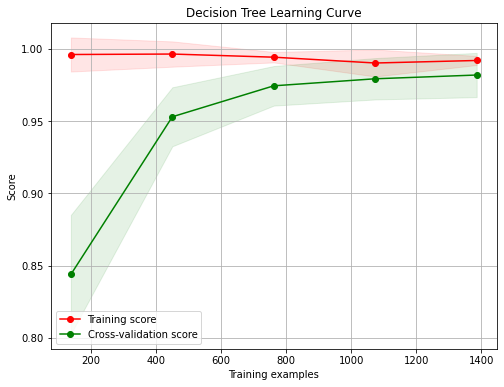

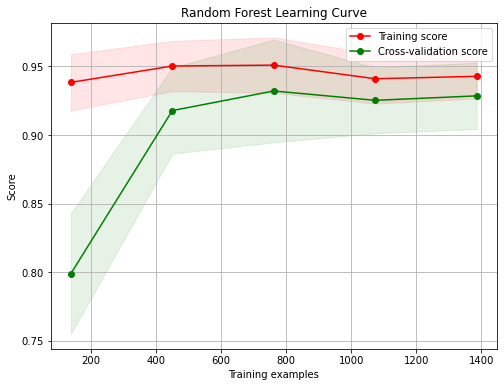

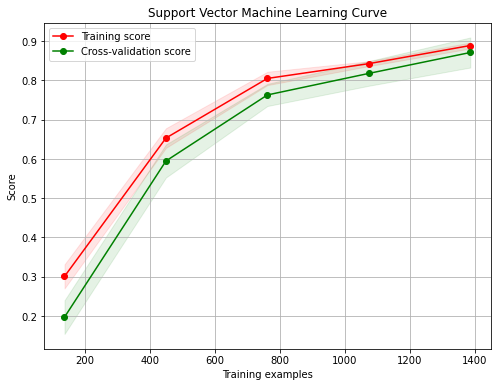

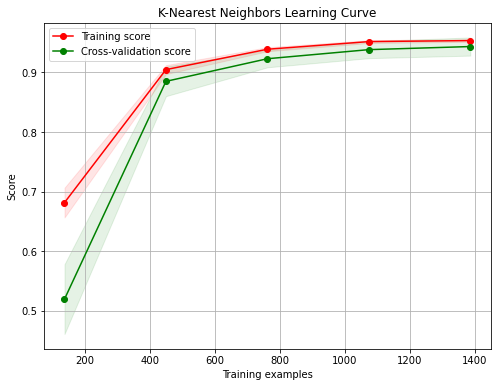

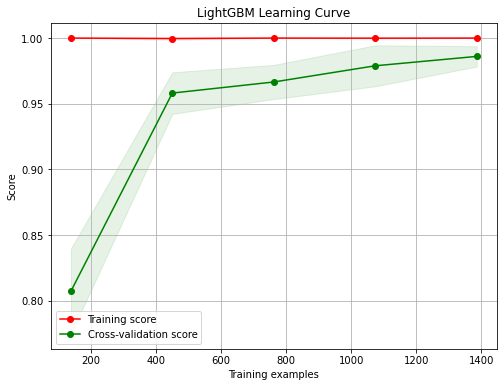

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy', title=''):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title(title)
    plt.grid()
    plt.show()

plot_learning_curve(cart_model, x_train_scale, y_train, cv=cv, title="Decision Tree Learning Curve")
plot_learning_curve(rf_model, x_train_scale, y_train, cv=cv, title="Random Forest Learning Curve")
plot_learning_curve(svc_model, x_train_scale, y_train, cv=cv, title="Support Vector Machine Learning Curve")
plot_learning_curve(knn_model, x_train_scale, y_train, cv=cv, title="K-Nearest Neighbors Learning Curve")   
plot_learning_curve(lgbm_model, x_train_scale, y_train, cv=cv, title="LightGBM Learning Curve")


Finally, we can make a new prediction using brand new data

In [56]:
new_data = {
    'N': [30],
    'P': [50],
    'K': [70],
    'temperature': [25.980453],
    'humidity': [48.635794],
    'ph': [7.423684],
    'rainfall': [59.648973]
}
new_data_df = pd.DataFrame(new_data)


In [57]:
new_data_df

,N,P,K,temperature,humidity,ph,rainfall
0,30,50,70,25.980453,48.635794,7.423684,59.648973


In [58]:
new_data_scaled = scale.transform(new_data_df)

In [59]:
new_data_scaled_df = pd.DataFrame(new_data_scaled, columns=new_data_df.columns)

In [60]:
predicted_crop_cart = cart_model.predict(new_data_scaled_df)
predicted_crop_rf = rf_model.predict(new_data_scaled_df)
predicted_crop_svc = svc_model.predict(new_data_scaled_df)
predicted_crop_knn = knn_model.predict(new_data_scaled_df)
predicted_crop_lgbm = lgbm_model.predict(new_data_scaled_df)

In [61]:
print("Predicted Crop (Decision Tree): ", predicted_crop_cart[0])
print("Predicted Crop (Random Forest):", predicted_crop_rf[0])
print("Predicted Crop (Support Vector Classifier):", predicted_crop_svc[0])
print("Predicted Crop (K-Nearest Neighbor:)", predicted_crop_knn[0])
print("Predicted Crop (LightGBM):", predicted_crop_lgbm[0])

Predicted Crop (Decision Tree):  mothbeans
Predicted Crop (Random Forest): chickpea
Predicted Crop (Support Vector Classifier): mothbeans
Predicted Crop (K-Nearest Neighbor:) mothbeans
Predicted Crop (LightGBM): mothbeans
